In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
import numpy as np

# For statistical testing and visualization
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load the data
data = pd.read_csv("merged_regression_data.csv")

# Drop rows with missing values for the variables we will use
data = data.dropna(subset=[
    'Percent_change_fast_food_restaurants_2011_2016', 
    'change_obese', 
    'Rural_2011', 
    'Household Income_2011', 
    'Obese_2011', 
    'African American_2011', 
    'Asian_2011', 
    'Hispanic_2011'
])


In [3]:
# Define treatment group: counties with a significant increase in fast food restaurants
# Use median increase as the threshold
median_increase = data['Percent_change_fast_food_restaurants_2011_2016'].median()
data['treatment'] = data['Percent_change_fast_food_restaurants_2011_2016'] > median_increase


In [4]:
# Covariates to use for matching
covariates = [
    'Rural_2011', 
    'Household Income_2011', 
    'Obese_2011', 
    'African American_2011', 
    'Asian_2011', 
    'Hispanic_2011'
]

# Logistic regression to calculate propensity scores
X = data[covariates]
y = data['treatment']

logistic = LogisticRegression(solver='liblinear')
data['propensity_score'] = logistic.fit(X, y).predict_proba(X)[:, 1]


In [5]:
# Nearest neighbor matching
treated = data[data['treatment'] == 1]
control = data[data['treatment'] == 0]

# Use nearest neighbors to find control matches
nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['propensity_score']])

# Find nearest neighbors for each treated unit
distances, indices = nn.kneighbors(treated[['propensity_score']])
matched_control = control.iloc[indices.flatten()]

# Combine treated units with their matched control units
matched_data = pd.concat([treated, matched_control])


In [6]:
# Calculate the average treatment effect on the treated (ATT)
att = matched_data[matched_data['treatment'] == 1]['change_obese'].mean() - \
      matched_data[matched_data['treatment'] == 0]['change_obese'].mean()

print(f"Average Treatment Effect on the Treated (ATT): {att}")


Average Treatment Effect on the Treated (ATT): 0.08364698247890945


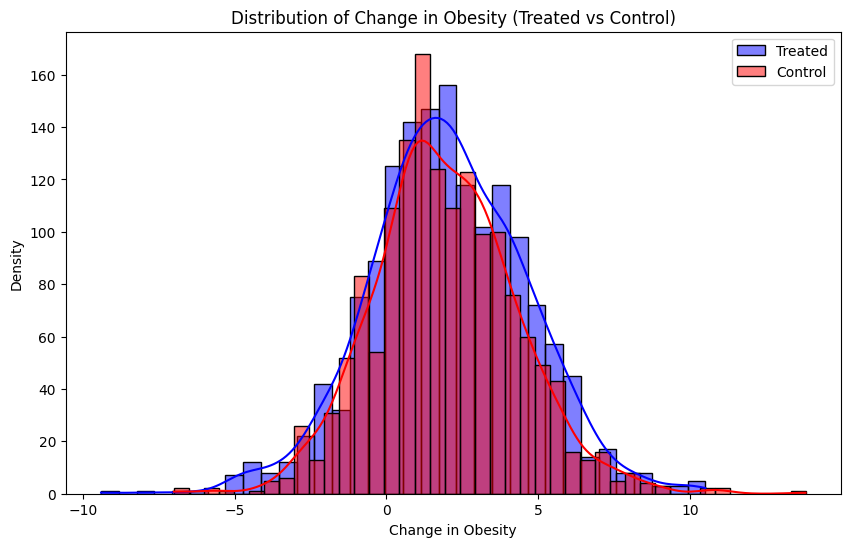

In [7]:
# Visualize the distribution of change in obesity in treated vs control groups
plt.figure(figsize=(10, 6))
sns.histplot(matched_data[matched_data['treatment'] == 1]['change_obese'], color="blue", label="Treated", kde=True)
sns.histplot(matched_data[matched_data['treatment'] == 0]['change_obese'], color="red", label="Control", kde=True)
plt.title("Distribution of Change in Obesity (Treated vs Control)")
plt.xlabel("Change in Obesity")
plt.ylabel("Density")
plt.legend()
plt.show()


In [9]:
# Perform a t-test to check significance
treated_obese = matched_data[matched_data['treatment'] == 1]['change_obese']
control_obese = matched_data[matched_data['treatment'] == 0]['change_obese']

# sm.stats.ttest_ind returns three values: t_stat, p_value, and degrees of freedom
t_stat, p_value, df = sm.stats.ttest_ind(treated_obese, control_obese)
print(f"T-statistic: {t_stat}, P-value: {p_value}")


T-statistic: 0.9361214939987844, P-value: 0.34928402883644494
